In [1]:
cd /home

/home


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import mlflow
import os

from sklearn.metrics import r2_score, mean_squared_error
from src.utils import get_metrics

from presentation.pipelines.steps.model_design import load_pt_model
from presentation.pipelines.steps.load_data import build_loader 


os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

%load_ext autoreload
%autoreload 2

2024-04-02 17:03:26.462168: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Pretraining

In [15]:
root = './presentation/results/lfgr/2024-03-26_04-14-20/'

astromer, config = load_pt_model(os.path.join(root, 'pretraining'))
config['data']

[INFO] Masking Query tokens only
[INFO] Masking Query tokens only


'./data/records/macho_clean/'

In [16]:
pd.DataFrame(config, index=[0])[['arch', 'mask_format', 'probed', 'same', 'scheduler', 'use_leak', 'lr', 'num_heads']]

,arch,mask_format,probed,same,scheduler,use_leak,lr,num_heads
0,base,Q,0.5,0.2,False,True,0.00001,4


In [17]:
data_path = './data/records/macho_clean/'
loaders = build_loader(data_path, 
                       config, 
                       batch_size=32,
                       clf_mode=False,
                       sampling=False,
                       normalize='zero-mean')

[INFO] Probed: 0.50 Random: 0.20 Same: 0.20
[INFO] Repeating dataset x1 times
[INFO] Loading PT task: Masking
[INFO] Probed: 0.50 Random: 0.20 Same: 0.20
[INFO] Repeating dataset x1 times
[INFO] Loading PT task: Masking
[INFO] Probed: 0.50 Random: 0.20 Same: 0.20
[INFO] Repeating dataset x1 times
[INFO] Loading PT task: Masking


In [18]:
output = astromer.predict(loaders['test'].take(4))

[INFO] Masking Query tokens only
[INFO] Masking Query tokens only
4/4 [==============================] - 2s 146ms/step


In [19]:
y = tf.ragged.boolean_mask(output['magnitudes'], output['probed_mask'])
y_hat = tf.ragged.boolean_mask(output['reconstruction'], output['probed_mask'])

r2_values = []
mse_values = []
for i in range(output['magnitudes'].shape[0]):
    y = tf.boolean_mask(output['magnitudes'][i], output['probed_mask'][i])
    y_hat = tf.boolean_mask(output['reconstruction'][i], output['probed_mask'][i])
    r2_values.append(r2_score(y, y_hat))
    mse_values.append(mean_squared_error(y, y_hat, squared=False))
    
test_r2   = np.mean(r2_values) 
test_mse = np.mean(mse_values)

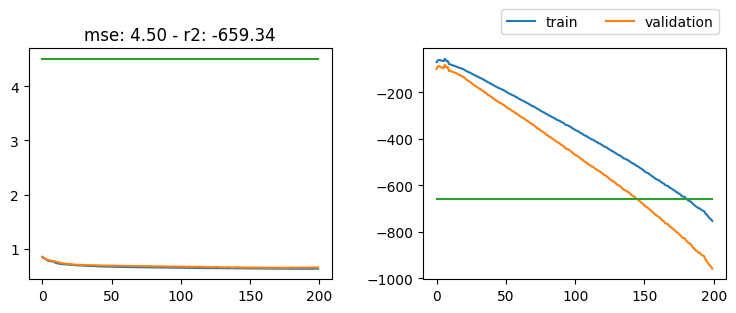

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3), gridspec_kw={'wspace':0.3})

for i, metric_name in enumerate(['epoch_loss', 'epoch_r_square']):
    train_metrics = get_metrics(os.path.join(root, 'pretraining', 'tensorboard', 'train'), 
                                metric_name=metric_name)
    valid_metrics = get_metrics(os.path.join(root, 'pretraining', 'tensorboard', 'validation'), 
                                metric_name=metric_name)
    axes[i].plot(train_metrics['step'], train_metrics['value'], label='train')
    axes[i].plot(valid_metrics['step'], valid_metrics['value'], label='validation')
    
    if metric_name == 'epoch_r_square':
        axes[i].plot([0, valid_metrics['step'].iloc[-1]], [test_r2, test_r2])
        continue
        
    if metric_name == 'epoch_loss':
        axes[i].plot([0, valid_metrics['step'].iloc[-1]], [test_mse, test_mse])
        continue
        
    axes[i].set_ylabel(metric_name)
    axes[i].set_xlabel('Epoch')
    
axes[0].set_title('mse: {:.2f} - r2: {:.2f}'.format(test_mse, test_r2))
axes[-1].legend(bbox_to_anchor=(1., 1.2), ncols=2)
plt.show()

Text(0.5, 1.0, 'True vs Predicted')

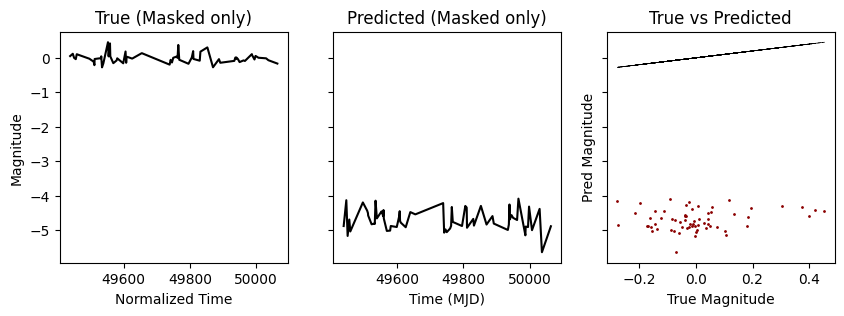

In [21]:
N = 1

x_true = tf.boolean_mask(output['magnitudes'][N], output['mask_in'][N])
x_pred = tf.boolean_mask(output['reconstruction'][N], output['mask_in'][N])
times = tf.boolean_mask(output['times'][N], output['mask_in'][N])

fig, axes = plt.subplots(1, 3, figsize=(10, 3), gridspec_kw={'wspace':0.2}, sharey=True)
axes[0].plot(times, x_true, color='k', label='True')
axes[0].set_title('True (Masked only)')
axes[0].set_ylabel('Magnitude')
axes[0].set_xlabel('Normalized Time')
axes[1].plot(times, x_pred, color='k', label='Prediction')
axes[1].set_title('Predicted (Masked only)')
axes[1].set_xlabel('Time (MJD)')
axes[2].scatter(x_true, x_pred, s=1, color='darkred')
axes[2].plot(x_true, x_true, linewidth=0.5, color='k', linestyle='--')

axes[2].set_xlabel('True Magnitude')
axes[2].set_ylabel('Pred Magnitude')
axes[2].set_title('True vs Predicted')

## Finetunem (MLFlow)

In [22]:
runs_df = mlflow.search_runs(experiment_ids=['334210612378422708'], 
                              search_all_experiments=True)
runs_df = runs_df[runs_df.status == 'FINISHED']
runs_df.columns

Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.test_acc', 'metrics.test_recall',
       'metrics.test_precision', 'metrics.test_f1',
       ...
       'tags.correct_loss', 'tags.bs', 'tags.data', 'tags.pt_weights',
       'tags.spc', 'tags.debug', 'tags.gpu', 'tags.lr', 'tags.head_dim',
       'tags.mixer'],
      dtype='object', length=104)

In [23]:
id_cols = ['tags.downstream_data', 'tags.arch', 'tags.m_alpha', 'tags.probed', 'tags.rs', 'tags.same', 'tags.spc']
    
selected = runs_df[id_cols+['tags.fold', 'metrics.val_rmse', 'metrics.test_r2']]

selected.groupby(id_cols).agg({'metrics.val_rmse': ['mean', 'std'],
                                                                          'metrics.test_r2': ['mean', 'std']})

KeyError: "['metrics.val_rmse', 'metrics.test_r2'] not in index"

## Classification (MLFlow)

In [24]:
runs_df = mlflow.search_runs(experiment_ids=['334210612378422708'], 
                              search_all_experiments=True)
runs_df = runs_df[runs_df.status == 'FINISHED']

runs_df = runs_df[['tags.downstream_data', 'tags.arch', 'tags.m_alpha', 
                   'tags.probed', 'tags.rs', 'tags.same', 'tags.spc', 
                   'tags.fold', 'metrics.test_f1']]
runs_df['tags.fold'] = runs_df['tags.fold'].astype(float)
runs_df['metrics.test_f1'] = runs_df['metrics.test_f1'].astype(float)

In [25]:
runs_df.groupby(['tags.downstream_data', 'tags.arch', 'tags.m_alpha', 
                 'tags.probed', 'tags.rs', 'tags.same', 'tags.spc']).agg({'metrics.test_f1': ['mean', 'std']})

metrics.test_f1  \
                                                                                               mean   
tags.downstream_data tags.arch tags.m_alpha  tags.probed tags.rs tags.same tags.spc                   
atlas                base      -1000000000.0 0.5         0.2     0.2       100             0.067525   
                                                                           20              0.067875   
                                                                           500             0.067523   
macho                base      -1000000000.0 0.5         0.2     0.2       100             0.055342   
                                                                           20              0.053188   
                                                                           500             0.055690   

                                                                                               
                                                                                          std  
tags.downstream_data tags.arch tags.m_alpha  tags.probed tags.rs tags.same tags.spc            
atlas                base      -1000000000.0 0.5         0.2     0.2       100       0.000976  
                                                                           20        0.000957  
                                                                           500       0.001629  
macho                base      -1000000000.0 0.5         0.2     0.2       100       0.000871  
                                                                           20        0.005003  
                                                                           500       0.000878